In [87]:
#GIS analysis and data processing algorithm for energy transport systems

#This code aims to provide an universally applicable algorithm for vertical and horizontal aggregation

#Horizontal integration 
# -	Automatically connect any nodes with one another without crossing. (Delaunay Triangulation) - Delaunay tessellation in N dimensions.
# -	Differentiation between land and sea connections. Can we give nodes a condition that if they are close to a coast (e.g. <10km) they act as harbours and can serve connections from land and sea? What if there is just one central node in each country? Can we say at least the node closest to the coast in each country with a sea border needs to contain the harbour property? What if one country connects two different oceans? (e.g. USA?)
# -	Not to many unnecessary connection (e.g. connections that run very close to each other)
# -	Pipeline factor
# -	Waterborne transport around land masses
# - making sure that every point is somehow connected with every other point to ensure feasibility

#Vertical integration
# -	Nodal mismatch
# -	Nodal merging
# - Combination with renewable energy potential geodata

# Backlog for next versions

# - investment modelling
# - toggling regions before clustering
# - integrate Gas grid GGM
# - consideration of storage when crossing countries

# Troubleshooting notes

# - defining candidate connections for pipeline invest
# - focusing on relevant problem at hand - distance between nodes

In [88]:
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from shapely.ops import triangulate
import pandas as pd
import searoute as sr
from matplotlib import pyplot as plt
import numpy as np
from itertools import combinations
from scipy.spatial import Delaunay
import random

In [89]:
#import geopandas included shapefiles
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
capitalcities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

#import external datasets, these datasets are currently for visualisation purposes only and are not necessary for the code to work
data_pth_input = "../data/data_input/" #define dataset source folder
cities = gpd.read_file(os.path.join(data_pth_input, "cities/ne_10m_populated_places.shp"))
ports = gpd.read_file(os.path.join(data_pth_input, "ports/WPI.shp"))
rivers = gpd.read_file(os.path.join(data_pth_input, "rivers/world_rivers.shp"))
deepsea = gpd.read_file(os.path.join(data_pth_input, "bm_world_3000mdepth/bm_world_3000mdepthres1.shp"))

#import plexos nodes and h2 terminals proposed locations csv
plexos_nodes = gpd.read_file(os.path.join(data_pth_input, "nodes/nodes.shp"))
plexos_nodes.head()

#data path definition for export files
data_pth_output = "../data/data_output/"

#define model results source folder
data_pth_model_results = "../model/.spinetoolbox/items/spineopttotable_xlsx/output/"

#define data results folder
data_pth_results = "../data/data_results/"

In [90]:
#Centrally define default model parameters

con_flow_cost = 2        #connection flow costs
node_slack_pen = 1000000     #slack penalty cost
con_cap_def = 100000        #default connection capacity
fix_ratio_io = 1            #default transmission losses
i = 0.06                    #default WACCC
lifetime = 20               #default lifetime
default_invest = 1000       #€/km/MW Pipeline default invest
bts = 0.8                   #share of nodes with balance_type_node

In [91]:
#Randomizing functions

#Randomizing function to create an array of random numbers as long as a given dataframe "trans_nodes" and multiply the value by a certain multiplicator "multi" (default = 0 < value < 1)
def randomize(trans_nodes, multi):
    random_nr = []
    rdnr = float
    for ind in trans_nodes.index:
        rdnr = random.random()*multi
        random_nr.append(rdnr)
    return random_nr

#Randomizing function to create an array of a certain number of random number "anzahl" and multiply the value by a certain multiplicator "multi" (default = 0 < value < 1)
def randomize1(anzahl, multi):
    random_nr = []
    rdnr = float
    for i in range(0, anzahl):
        rdnr = random.random()*multi
        random_nr.append(rdnr)
    return random_nr


In [92]:
#Setting base nodes for the energy system
nodes = plexos_nodes #source dataframe from plexos composed of ["name", "class", "attribute", "value1", "attribute", "value"]
nodes = nodes.drop(columns=["attribute","attribute_","class"])  #deleting unneccesary columns
nodes = nodes.rename(columns={"value1":"x", "value2":"y"})      #renaming coordinate columns
nodes["y"] = nodes["y"]*(-1)                                    #transforming latitude values to match Spine GUI requirement - can be left out for other frameworks
nodes["el_node"] = nodes['name'] + "_el"                        #defining name for electricity nodes
nodes["h2_node"] = nodes['name'] + "_h2"                        #defining name for hydrogen nodes

#Defining random source nodes (balance type none or node).
bal_ty = []
for c in nodes.index:
    if random.random() < bts:                                   #The value compared equals the share of nodes with balance type node
        bal_ty.append("balance_type_node")
    else:
        bal_ty.append("balance_type_none")

nodes["balance_type"] = bal_ty

nodes["el_demand"] = 1                                          #randomize(nodes, 100)
nodes["h2_demand"] = randomize(nodes, 10)
nodes = nodes.reindex(columns=["name", "geometry", "el_node", "h2_node", "el_demand", "h2_demand", "balance_type", "x", "y"])
nodes_res = nodes

nodes.head()

name                    geometry    el_node    h2_node  el_demand   
0  AF-AGO  POINT (17.87389 -11.20269)  AF-AGO_el  AF-AGO_h2          1  \
1  AF-BDI   POINT (29.91889 -3.37306)  AF-BDI_el  AF-BDI_h2          1   
2  AF-BEN     POINT (2.31583 9.30769)  AF-BEN_el  AF-BEN_h2          1   
3  AF-BFA   POINT (-1.56159 12.23833)  AF-BFA_el  AF-BFA_h2          1   
4  AF-BWA  POINT (24.68487 -22.32847)  AF-BWA_el  AF-BWA_h2          1   

   h2_demand       balance_type          x          y  
0   0.873795  balance_type_node  17.873887  11.202692  
1   9.134629  balance_type_node  29.918886   3.373056  
2   0.612635  balance_type_none   2.315834  -9.307690  
3   3.148508  balance_type_none  -1.561593 -12.238333  
4   4.216042  balance_type_node  24.684866  22.328474

In [93]:
#randomly generated time series

def produce_time_series(input_df, ts_name):
    transfer = input_df
    zeitreihe = []
    zeitreihe_str = []
    monate = ["2015-01-01T00:00:00","2015-02-01T00:00:00","2015-03-01T00:00:00", "2015-04-01T00:00:00", "2015-05-01T00:00:00", "2015-06-01T00:00:00", "2015-07-01T00:00:00", "2015-08-01T00:00:00", "2015-09-01T00:00:00", "2015-10-01T00:00:00", "2015-11-01T00:00:00", "2015-12-01T00:00:00"]
    
    df_min = randomize1(12, 100)

    for i in transfer.index:
        zeitreihe = zeitreihe + ['']            #Platzhalterliste
        zeitreihe_str = zeitreihe_str + ['']    #Platzhalterliste
    for j in range(len(transfer)):              #Schleife zum einlesen des Zuflusses ALLER Nodes zu jeweils einer Zeitreihe
        for i in range(len(monate)-1):          #Schleife zum einlesen des Zuflusses EINES Nodes zu seiner Zeitreihe
            zeitreihe[j] = zeitreihe[j] + '"' + monate[i] + '": ' + """str(df_min[i])""" + ', '   #min_flow von Monat i, in der Region j
        zeitreihe[j] = zeitreihe[j].removesuffix(', ')
        zeitreihe_str[j] = '{"type": "time_series", "data": {' + zeitreihe[j] + '}}'

    transfer[ts_name] = zeitreihe_str
    #transfer.cf_timeseries[0]
    return transfer

test_df = produce_time_series(nodes, "el_demand_ts")
test_df = produce_time_series(nodes, "h2_demand_ts")
test_df["node_slack_penalty"] = node_slack_pen
test_df = test_df.to_crs(epsg=4326) #test mit epsg=32642 - erstmal rausgenommen

#test_df.to_excel(os.path.join(data_pth_export, "transport_objects.xlsx"), sheet_name='nodes')

test_df

name                     geometry    el_node    h2_node  el_demand   
0    AF-AGO   POINT (17.87389 -11.20269)  AF-AGO_el  AF-AGO_h2          1  \
1    AF-BDI    POINT (29.91889 -3.37306)  AF-BDI_el  AF-BDI_h2          1   
2    AF-BEN      POINT (2.31583 9.30769)  AF-BEN_el  AF-BEN_h2          1   
3    AF-BFA    POINT (-1.56159 12.23833)  AF-BFA_el  AF-BFA_h2          1   
4    AF-BWA   POINT (24.68487 -22.32847)  AF-BWA_el  AF-BWA_h2          1   
..      ...                          ...        ...        ...        ...   
254  SA-PER   POINT (-75.01515 -9.18997)  SA-PER_el  SA-PER_h2          1   
255  SA-PRY  POINT (-58.44383 -23.44250)  SA-PRY_el  SA-PRY_h2          1   
256  SA-SUR    POINT (-56.02778 3.91931)  SA-SUR_el  SA-SUR_h2          1   
257  SA-URY  POINT (-55.76584 -32.52278)  SA-URY_el  SA-URY_h2          1   
258  SA-VEN    POINT (-66.58973 6.42375)  SA-VEN_el  SA-VEN_h2          1   

     h2_demand       balance_type          x          y   
0     0.873795  balance_type_node  17.873887  11.202692  \
1     9.134629  balance_type_node  29.918886   3.373056   
2     0.612635  balance_type_none   2.315834  -9.307690   
3     3.148508  balance_type_none  -1.561593 -12.238333   
4     4.216042  balance_type_node  24.684866  22.328474   
..         ...                ...        ...        ...   
254   2.671416  balance_type_none -75.015152   9.189967   
255   1.202992  balance_type_node -58.443832  23.442503   
256   0.301977  balance_type_node -56.027783  -3.919305   
257   3.596369  balance_type_node -55.765835  32.522779   
258   9.612915  balance_type_node -66.589730  -6.423750   

                                          el_demand_ts   
0    {"type": "time_series", "data": {"2015-01-01T0...  \
1    {"type": "time_series", "data": {"2015-01-01T0...   
2    {"type": "time_series", "data": {"2015-01-01T0...   
3    {"type": "time_series", "data": {"2015-01-01T0...   
4    {"type": "time_series", "data": {"2015-01-01T0...   
..                                                 ...   
254  {"type": "time_series", "data": {"2015-01-01T0...   
255  {"type": "time_series", "data": {"2015-01-01T0...   
256  {"type": "time_series", "data": {"2015-01-01T0...   
257  {"type": "time_series", "data": {"2015-01-01T0...   
258  {"type": "time_series", "data": {"2015-01-01T0...   

                                          h2_demand_ts  node_slack_penalty  
0    {"type": "time_series", "data": {"2015-01-01T0...             1000000  
1    {"type": "time_series", "data": {"2015-01-01T0...             1000000  
2    {"type": "time_series", "data": {"2015-01-01T0...             1000000  
3    {"type": "time_series", "data": {"2015-01-01T0...             1000000  
4    {"type": "time_series", "data": {"2015-01-01T0...             1000000  
..                                                 ...                 ...  
254  {"type": "time_series", "data": {"2015-01-01T0...             1000000  
255  {"type": "time_series", "data": {"2015-01-01T0...             1000000  
256  {"type": "time_series", "data": {"2015-01-01T0...             1000000  
257  {"type": "time_series", "data": {"2015-01-01T0...             1000000  
258  {"type": "time_series", "data": {"2015-01-01T0...             1000000  

[259 rows x 12 columns]

In [94]:
#Defining global regions

values = ["Canada", "United States of America"]
north_america = world.loc[world['name'].isin(values)]
values = ["Mexico", "Belize", "Guatemala", "Panama", "Nicaragua", "Costa Rica", "San Jose", "El Salvador", "Honduras"]
central_america = world.loc[world['name'].isin(values)]
values = ["Cuba", "Bahamas", "Trinidad and Tobago", "Haiti", "Dominican Rep.", "Antigua and Barbuda", "Barbados", "Jamaica", "Puerto Rico"]
caribbean = world.loc[world['name'].isin(values)]
values = ["Colombia", "Venezuela", "Guyana", "Suriname", "Brazil", "Argentina", "Uruguay", "Paraguay", "Bolivia", "Falkland Is."]
east_coast_south_america = world.loc[world['name'].isin(values)]
values = ["Ecuador", "Peru", "Chile"]
west_coast_south_america = world.loc[world['name'].isin(values)]
values = ["Norway", "Sweden", "Finland", "Lithuania", "Estonia", "Latvia", "United Kingdom", "Ireland", "Iceland", "Denmark"]
northern_europe = world.loc[world['name'].isin(values)]
values = ["Germany", "Netherlands", "Belgium", "France", "Austria", "Switzerland", "Luxembourg", "Liechtenstein"]
central_europe = world.loc[world['name'].isin(values)]
values = ["Spain", "Portugal", "Italy", "Greece", "Croatia", "Serbia", "Albania", "Montenegro", "Kosovo", "North Macedonia", "Slovenia","Andorra", "Bosnia and Herz.", "Cyprus", "N. Cyprus"]
southern_europe = world.loc[world['name'].isin(values)]
values = ["Poland", "Czechia", "Slovakia", "Hungary", "Romania", "Ukraine", "Moldova", "Bulgaria"]
eastern_europe = world.loc[world['name'].isin(values)]
values = ["Russia", "Belarus"]
russia_belarus = world.loc[world['name'].isin(values)]
values = ["Morocco", "Tunisia", "Egypt", "Algeria", "Libya"]
northern_africa = world.loc[world['name'].isin(values)]
values = ["Chad", "Sudan", "S. Sudan", "Central African Rep.", "Mali", "Niger", "Mauritania", "W. Sahara"]
sahel_zone = world.loc[world['name'].isin(values)]
values = ["Ghana", "Senegal", "Guinea", "Nigeria", "Togo", "Benin", "Burkina Faso", "Côte d'Ivoire", "Sierra Leone", "Liberia", "Gambia", "Guinea-Bissau"]
north_west_coast_africa = world.loc[world['name'].isin(values)]
values = ["Eritrea", "Somalia", "Somaliland", "Ethiopia", "Tanzania", "Kenya","Mozambique", "Madagascar", "Djibouti"]
east_coast_africa = world.loc[world['name'].isin(values)]
values = ["Dem. Rep. Congo", "Gambia", "Botswana", "Burundi", "Rwanda", "Uganda", "Malawi", "Zimbabwe", "Zambia"]
south_central_africa = world.loc[world['name'].isin(values)]
values = ["Angola", "Cameroon", "Congo", "Eq. Guinea", "Gabon"]
west_coast_africa = world.loc[world['name'].isin(values)]
values = ["South Africa", "Namibia", "eSwatini", "Lesotho"]
southern_africa = world.loc[world['name'].isin(values)]
values = ["Iraq", "Syria", "Israel", "Palestine", "Lebanon", "Jordan", "Saudi Arabia", "United Arab Emirates", "Qatar", "Turkey", "Armenia", "Georgia", "Azerbaijan", "Bahrain", "Oman", "Yemen", "Azerbaijan", "Kuwait"]
middle_east = world.loc[world['name'].isin(values)]
values = ["Uzbekistan", "Tajikistan", "Kazakhstan", "Turkmenistan", "Kyrgyzstan"]
central_asia = world.loc[world['name'].isin(values)]
values = ["India", "Afghanistan", "Pakistan", "Iran", "Bangladesh", "Bhutan", "Nepal", "Sri Lanka"]
southern_asia = world.loc[world['name'].isin(values)]
values = ["China", "Japan", "North Korea", "South Korea", "Mongolia", "Taiwan"]
eastern_asia = world.loc[world['name'].isin(values)]
values = ["Indonesia", "Singapore", "Thailand", "Vietnam", "Laos", "Myanmar", "Brunei", "Cambodia", "Malaysia", "Philippines", "Timor-Leste"]
south_eastern_asia = world.loc[world['name'].isin(values)]
values = ["Australia","New Zealand", "Fji", "New Caledonia", "Papua New Guinea", "Solomon Is.", "Vanuatu"]
australia_oceania = world.loc[world['name'].isin(values)]

In [95]:
#Transforming Shapely Points to Numpy Array and triangulating it

tri_work_points = plexos_nodes["geometry"]

listarray = []
for pp in tri_work_points:
    listarray.append([pp.x, pp.y])
tri_work_array = np.array(listarray)

plexos_nodes_triangulation = Delaunay(tri_work_array)

# Now I have one shapefile with building polygons. I would like to convert them into lines split at each vertex, keeping the original source info as an attribute (Name).
# Use .boundary method to convert the polygons to lines, and .coords to fetch the coordinates of each line segment. Then .explode:
# https://gis.stackexchange.com/questions/436679/how-to-convert-polygons-to-line-segments-using-python

coord_groups = [plexos_nodes_triangulation.points[x] for x in plexos_nodes_triangulation.simplices] #plexos_nodes_triangulation ist eine Variable von weiter oben die die Dreiecke der Delaunay Triangulation beinahtlet und hier in ein gpd Polygon umgebaut wird.
polygons = [Polygon(x) for x in coord_groups]

df = gpd.GeoDataFrame(columns=["geometry"])     #the polygon file is a list array which is now defined as "geometry" attribute of the gdf
df["geometry"] = polygons
df["geometry"] = df.geometry.boundary
dfline = gpd.GeoDataFrame(data=df, geometry='geometry')

def explodeLine(row):
    """A function to return all segments of a line as a list of linestrings"""
    coords = row.geometry.coords #Create a list of all line node coordinates
    parts = []
    for part in zip(coords, coords[1:]): #For each start and end coordinate pair
        parts.append(LineString(part)) #Create a linestring and append to parts list
    return parts

dfline["tempgeom"] = dfline.apply(lambda x: explodeLine(x), axis=1)     #Create a list of all line segments explodeLine(dfline)
dfline = dfline.explode("tempgeom")                                     #Explode it so each segment becomes a row (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html)

dfline = gpd.GeoDataFrame(data=dfline, geometry='tempgeom')
dfline = dfline.drop('geometry', axis=1)
dfline.crs = df.crs                                                     #apply coordinate system
dfline = dfline.rename_geometry("geometry")

dfline = dfline.reset_index()
dfline = dfline.drop("index", axis=1)
dfline["starts_temp"] = dfline.apply(lambda x: [y for y in x['geometry'].coords[0]], axis=1)
dfline["ends_temp"] = dfline.apply(lambda x: [y for y in x['geometry'].coords[-1]], axis=1)

def retracer(df_retracer, station):
    geo_xy = []
    for ind in dfline.index:
        xy = df_retracer.loc[ind][station]
        slc = Point(xy)
        geo_xy.append(slc)
    return geo_xy

dfline["starts"] = retracer(dfline, "starts_temp")
dfline = dfline.drop("starts_temp", axis=1)
dfline["ends"] = retracer(dfline, "ends_temp")
dfline = dfline.drop("ends_temp", axis=1)

nodes_comp = nodes_res
nodes_comp["starts"] = nodes_res["geometry"]
nodes_comp["ends"] = nodes_res["geometry"]
nodes_comp = nodes_comp.drop(["x","y","el_node","balance_type","el_demand","h2_demand","el_demand_ts","h2_demand_ts", "node_slack_penalty"], axis=1)
dfline = dfline.merge(nodes_comp, on="starts", how="left")
dfline = dfline.rename(columns={"geometry_x":"geometry_line", "ends_x":"ends", "name":"node1", "h2_node":"h2_node1"})
dfline = dfline.drop(["geometry_y","ends_y"], axis=1)
dfline = dfline.merge(nodes_comp, on="ends", how="left")
dfline = dfline.rename(columns={"starts_x":"starts", "name":"node2", "h2_node":"h2_node2"})
dfline = dfline.drop(["starts_y", "node1", "node2", "starts", "ends"], axis=1)
dfline["name"] = dfline["h2_node1"]+"_"+dfline["h2_node2"]
dfline = dfline.set_geometry(dfline["geometry_line"])
dfline = dfline.drop(["geometry_line"], axis=1)
dfline["connection_flow_cost"] = con_flow_cost
dfline["connection_capacity"] = con_cap_def

#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html
dfline = dfline.set_crs(32642, allow_override=True)
dfline["length"] = dfline.length    #calculating the length of the linestring elements
dfline = dfline.set_crs(4326, allow_override=True)

#including investment
# dfline["connection_investment_lifetime"] = lifetime
# dfline["connection_investment_variable_type"] = "variable_type_continuous"
# dfline["candidate_connections"] = 10000
# dfline["connection_investment_cost"] = default_invest * (1+i)^lifetime/((1+i)^lifetime-1) * dfline["length"]

dfline = dfline.reindex(columns=["name", "h2_node1", "h2_node2", "geometry", "connection_flow_cost", "connection_capacity", "length"])

#Unterteilen der Line Objects nach lenght
#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html

dfline_ship = dfline.drop(dfline[dfline.length<=80].index)
dfline_short = dfline.drop(dfline[dfline.length>80].index)

dfline_short.head()

C:\Users\oliver\AppData\Local\Temp\ipykernel_10960\2321862907.py:90: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dfline_ship = dfline.drop(dfline[dfline.length<=80].index)
C:\Users\oliver\AppData\Local\Temp\ipykernel_10960\2321862907.py:91: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dfline_short = dfline.drop(dfline[dfline.length>80].index)


name      h2_node1      h2_node2   
2  EU-ISL_h2_AS-RUS-NW_h2     EU-ISL_h2  AS-RUS-NW_h2  \
3  NA-USA-GU_h2_OC-PNG_h2  NA-USA-GU_h2     OC-PNG_h2   
4     OC-PNG_h2_OC-NZL_h2     OC-PNG_h2     OC-NZL_h2   
5  OC-NZL_h2_NA-USA-GU_h2     OC-NZL_h2  NA-USA-GU_h2   
6  OC-PNG_h2_OC-AUS-QL_h2     OC-PNG_h2  OC-AUS-QL_h2   

                                            geometry  connection_flow_cost   
2  LINESTRING (-19.02084 64.96305, 49.39031 63.56...                     2  \
3  LINESTRING (144.75755 13.45013, 143.95555 -6.3...                     2   
4  LINESTRING (143.95555 -6.31499, 174.88597 -40....                     2   
5  LINESTRING (174.88597 -40.90056, 144.75755 13....                     2   
6  LINESTRING (143.95555 -6.31499, 145.17972 -24....                     2   

   connection_capacity     length  
2               100000  68.425466  
3               100000  19.781383  
4               100000  46.398838  
5               100000  62.142726  
6               100000  18.000454

In [96]:
#dropping the very long pipelines (mostly through the arctic)
h2_pipelines = dfline.drop(dfline[dfline.length>=80].index)

#dropping all pipelines crossing the deep sea
poly_union = deepsea.geometry.unary_union #combining all deepsea polygons to one multipolygon
subset = gpd.sjoin(h2_pipelines, deepsea, how='inner', predicate='intersects') #pipelines that cross the deepsea
h2_pipelines = h2_pipelines.drop(index = subset.index) #dropping the deepsea pipelines by indexes

h2_pipelines

C:\Users\oliver\AppData\Local\Temp\ipykernel_10960\3196964230.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  h2_pipelines = dfline.drop(dfline[dfline.length>=80].index)


name      h2_node1      h2_node2   
6        OC-PNG_h2_OC-AUS-QL_h2     OC-PNG_h2  OC-AUS-QL_h2  \
9        EU-FIN_h2_AS-RUS-NW_h2     EU-FIN_h2  AS-RUS-NW_h2   
12    AS-RUS-NW_h2_AS-RUS-SI_h2  AS-RUS-NW_h2  AS-RUS-SI_h2   
13    AS-RUS-SI_h2_AS-RUS-FE_h2  AS-RUS-SI_h2  AS-RUS-FE_h2   
15    AS-RUS-SI_h2_AS-RUS-NW_h2  AS-RUS-SI_h2  AS-RUS-NW_h2   
...                         ...           ...           ...   
1518     AS-TWN_h2_AS-CHN-HK_h2     AS-TWN_h2  AS-CHN-HK_h2   
1520        AS-PHL_h2_AS-TWN_h2     AS-PHL_h2     AS-TWN_h2   
1521     AS-TWN_h2_AS-CHN-FU_h2     AS-TWN_h2  AS-CHN-FU_h2   
1522  AS-CHN-FU_h2_AS-CHN-HK_h2  AS-CHN-FU_h2  AS-CHN-HK_h2   
1523     AS-CHN-HK_h2_AS-TWN_h2  AS-CHN-HK_h2     AS-TWN_h2   

                                               geometry  connection_flow_cost   
6     LINESTRING (143.95555 -6.31499, 145.17972 -24....                     2  \
9     LINESTRING (25.74815 61.92411, 49.39031 63.56293)                     2   
12    LINESTRING (49.39031 63.56293, 93.19097 58.68187)                     2   
13    LINESTRING (93.19097 58.68187, 134.75310 64.61...                     2   
15    LINESTRING (93.19097 58.68187, 49.39031 63.56293)                     2   
...                                                 ...                   ...   
1518  LINESTRING (120.96052 23.69781, 114.16611 22.3...                     2   
1520  LINESTRING (121.77402 12.87972, 120.96052 23.6...                     2   
1521  LINESTRING (120.96052 23.69781, 118.07238 25.7...                     2   
1522  LINESTRING (118.07238 25.77570, 114.16611 22.3...                     2   
1523  LINESTRING (114.16611 22.32394, 120.96052 23.6...                     2   

      connection_capacity     length  
6                  100000  18.000454  
9                  100000  23.698886  
12                 100000  44.071793  
13                 100000  41.983958  
15                 100000  44.071793  
...                   ...        ...  
1518               100000   6.931912  
1520               100000  10.848633  
1521               100000   3.557947  
1522               100000   5.212823  
1523               100000   6.931912  

[1285 rows x 7 columns]

In [97]:
#mit diesem Skript werden aus der Liste aus der proposed_h2_terminals.csv Datei die einzelnen h2 terminals in ein dataframe geschrieben und die Koordinaten in ein funktionierendes geometry Objekt verpackt.
h2_terminals = pd.read_csv(os.path.join(data_pth_input, "proposed_h2_terminals/proposed_h2_terminals.csv"), delimiter=";") #einlesen der csv in ein dataframe

h2_terminal_points = h2_terminals.apply(lambda row: Point(row.longitude, row.latitude), axis=1) #axis=1 macht, dass es von Reihe zu Reihe geht und nicht von Spalte zu Spalte
#first lon then lat
h2_terminal_points.head() #hier sind dann die geometry informationen drinne

h2_terminals = gpd.GeoDataFrame(h2_terminals, geometry=h2_terminal_points) #hier werden die geo infos in die neue Spalte geometry im geodataframe eingefügt
h2_terminals.crs = {"init": "epsg:4326"} #anpassan der Projektion

h2_terminals.head()

c:\Users\oliver\mambaforge\envs\geo_tools\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


name           city    node           region   latitude   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe  51.948455  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe  37.961098   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe  39.463713   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe  45.205817   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east  36.825941   

   longitude                   geometry  
0   4.140296   POINT (4.14030 51.94846)  
1  -8.878688  POINT (-8.87869 37.96110)  
2  -0.358820  POINT (-0.35882 39.46371)  
3  12.293656  POINT (12.29366 45.20582)  
4  36.177898  POINT (36.17790 36.82594)

In [98]:
def calculate_searoute(origin, destination):
    origin_lon = h2_terminals.query(f"name=='{origin}'")["longitude"].values
    origin_lat = h2_terminals.query(f"name=='{origin}'")["latitude"].values
    destination_lon = h2_terminals.query(f"name=='{destination}'")["longitude"].values
    destination_lat = h2_terminals.query(f"name=='{destination}'")["latitude"].values
    p_origin = [origin_lon[0], origin_lat[0]]
    p_destination = [destination_lon[0], destination_lat[0]]
    route = sr.searoute(p_origin, p_destination, speed_knot = 13, append_orig_dest= True)
    sr_geo = LineString(route["geometry"]["coordinates"])
    return route["properties"]["duration_hours"], route["properties"]["length"], route["geometry"]["coordinates"], sr_geo

names = (h2_terminals.name.to_list())
combinations_names = np.array(list(combinations(names, 2)))

df_sr = pd.DataFrame(columns=["origin", "destination"])

df_sr["origin"] = combinations_names[:,0]
df_sr["destination"] = combinations_names[:,1]

duration_list = []
length_list = []
coord_list = []
geo_list = []

for i in df_sr.index:
    o = df_sr.iloc[i]["origin"]
    d = df_sr.iloc[i]["destination"]
    duration, length, coord, sr_geo_out = calculate_searoute(o, d)
    duration_list.append(duration)
    length_list.append(length)
    coord_list.append(coord)
    geo_list.append(sr_geo_out)

df_sr["duration_hours"] = duration_list
df_sr["length_km"] = length_list
df_sr["coordinates"] = coord_list
df_sr = gpd.GeoDataFrame(df_sr, geometry=geo_list, crs="EPSG:4326")
df_sr["name"] = df_sr["origin"] + "_" + df_sr["destination"]
df_sr["connection_type"] = "connection_type_normal"
df_sr["fix_ratio_out_in_connection_flow"] = fix_ratio_io
df_sr["connection_capacity"] = con_cap_def
df_sr["connection_flow_cost"] = con_flow_cost

df_sr

origin            destination  duration_hours   
0       h2_terminal_EU-NLD     h2_terminal_EU-PRT       87.758152  \
1       h2_terminal_EU-NLD     h2_terminal_EU-ESP      142.161685   
2       h2_terminal_EU-NLD     h2_terminal_EU-ITA      238.200563   
3       h2_terminal_EU-NLD     h2_terminal_AS-TUR      264.958636   
4       h2_terminal_EU-NLD     h2_terminal_EU-SWE       84.681372   
..                     ...                    ...             ...   
625     h2_terminal_AF-TZA  h2_terminal_NA-USA-HA      802.412905   
626     h2_terminal_AF-TZA  h2_terminal_OC-AUS-WA      362.734591   
627     h2_terminal_AF-EGY  h2_terminal_NA-USA-HA      854.491681   
628     h2_terminal_AF-EGY  h2_terminal_OC-AUS-WA      479.138395   
629  h2_terminal_NA-USA-HA  h2_terminal_OC-AUS-WA      501.703717   

        length_km                                        coordinates   
0     2112.865259  [[4.140296, 51.948455], [4.047588, 51.835844],...  \
1     3422.684739  [[4.140296, 51.948455], [4.047588, 51.835844],...   
2     5734.916766  [[4.140296, 51.948455], [4.047588, 51.835844],...   
3     6379.144123  [[4.140296, 51.948455], [4.047588, 51.835844],...   
4     2038.788712  [[4.140296, 51.948455], [4.047588, 51.835844],...   
..            ...                                                ...   
625  19318.893102  [[39.704938, -9.969284], [41, -10], [43, -12],...   
626   8733.198013  [[39.704938, -9.969284], [41, -10], [43, -12],...   
627  20572.741717  [[32.449177, 29.916289], [32.6, 29.7], [32.557...   
628  11535.736008  [[32.449177, 29.916289], [32.6, 29.7], [33.75,...   
629  12079.018688  [[-156.012384, 19.735625], [-155, 20], [-157.6...   

                                              geometry   
0    LINESTRING (4.14030 51.94846, 4.04759 51.83584...  \
1    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
2    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
3    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
4    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
..                                                 ...   
625  LINESTRING (39.70494 -9.96928, 41.00000 -10.00...   
626  LINESTRING (39.70494 -9.96928, 41.00000 -10.00...   
627  LINESTRING (32.44918 29.91629, 32.60000 29.700...   
628  LINESTRING (32.44918 29.91629, 32.60000 29.700...   
629  LINESTRING (-156.01238 19.73562, -155.00000 20...   

                                            name         connection_type   
0          h2_terminal_EU-NLD_h2_terminal_EU-PRT  connection_type_normal  \
1          h2_terminal_EU-NLD_h2_terminal_EU-ESP  connection_type_normal   
2          h2_terminal_EU-NLD_h2_terminal_EU-ITA  connection_type_normal   
3          h2_terminal_EU-NLD_h2_terminal_AS-TUR  connection_type_normal   
4          h2_terminal_EU-NLD_h2_terminal_EU-SWE  connection_type_normal   
..                                           ...                     ...   
625     h2_terminal_AF-TZA_h2_terminal_NA-USA-HA  connection_type_normal   
626     h2_terminal_AF-TZA_h2_terminal_OC-AUS-WA  connection_type_normal   
627     h2_terminal_AF-EGY_h2_terminal_NA-USA-HA  connection_type_normal   
628     h2_terminal_AF-EGY_h2_terminal_OC-AUS-WA  connection_type_normal   
629  h2_terminal_NA-USA-HA_h2_terminal_OC-AUS-WA  connection_type_normal   

     fix_ratio_out_in_connection_flow  connection_capacity   
0                                   1               100000  \
1                                   1               100000   
2                                   1               100000   
3                                   1               100000   
4                                   1               100000   
..                                ...                  ...   
625                                 1               100000   
626                                 1               100000   
627                                 1               100000   
628                                 1               100000   
629                               

In [99]:
con_line1 = h2_terminals
con_line1 = con_line1.drop(columns=["latitude","longitude"])
con_line1 = con_line1.rename_geometry("geo1")
con_line2 = plexos_nodes
con_line2 = con_line2.drop(columns=["attribute","value1","attribute_","value2","class"])
con_line2 = con_line2.rename_geometry("geo2")
con_line2 = con_line2.rename(columns={"name":"node"})

con_line = con_line1.merge(con_line2, on="node")

con_line_geo = []
for ind in con_line.index:
    coord_t = con_line.loc[ind]["geo1"]
    coord_n = con_line.loc[ind]["geo2"]
    clg = LineString([coord_t, coord_n])
    con_line_geo.append(clg)

con_line = gpd.GeoDataFrame(con_line, geometry=con_line_geo, crs="EPSG:4326")
con_line = con_line.drop(columns=["geo1","geo2"])

#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html
con_line["length"] = con_line.length #ermittle die Längen der einzelnen Linestring Elemente

con_line["connection_capacity"] = con_cap_def
con_line["connection_flow_cost"] = con_flow_cost
con_line["connection_type"] = "connection_type_normal"
con_line["node2"] = con_line["node"] + "_h2"
con_line = con_line.rename(columns={"name":"node1"})

con_line["name"] = con_line["node1"] + "_" + con_line["node2"]

con_line.head()


C:\Users\oliver\AppData\Local\Temp\ipykernel_10960\2139731284.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  con_line["length"] = con_line.length #ermittle die Längen der einzelnen Linestring Elemente


node1           city    node           region   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east   

                                            geometry    length   
0    LINESTRING (4.14030 51.94846, 5.29127 52.13263)  1.165613  \
1  LINESTRING (-8.87869 37.96110, -8.22445 39.39987)  1.580536   
2  LINESTRING (-0.35882 39.46371, -3.74922 40.46367)  3.534787   
3  LINESTRING (12.29366 45.20582, 12.56738 41.87194)  3.345095   
4  LINESTRING (36.17790 36.82594, 35.24332 38.96375)  2.333161   

   connection_capacity  connection_flow_cost         connection_type   
0               100000                     2  connection_type_normal  \
1               100000                     2  connection_type_normal   
2               100000                     2  connection_type_normal   
3               100000                     2  connection_type_normal   
4               100000                     2  connection_type_normal   

       node2                          name  
0  EU-NLD_h2  h2_terminal_EU-NLD_EU-NLD_h2  
1  EU-PRT_h2  h2_terminal_EU-PRT_EU-PRT_h2  
2  EU-ESP_h2  h2_terminal_EU-ESP_EU-ESP_h2  
3  EU-ITA_h2  h2_terminal_EU-ITA_EU-ITA_h2  
4  AS-TUR_h2  h2_terminal_AS-TUR_AS-TUR_h2

(-180.0, 180.0)

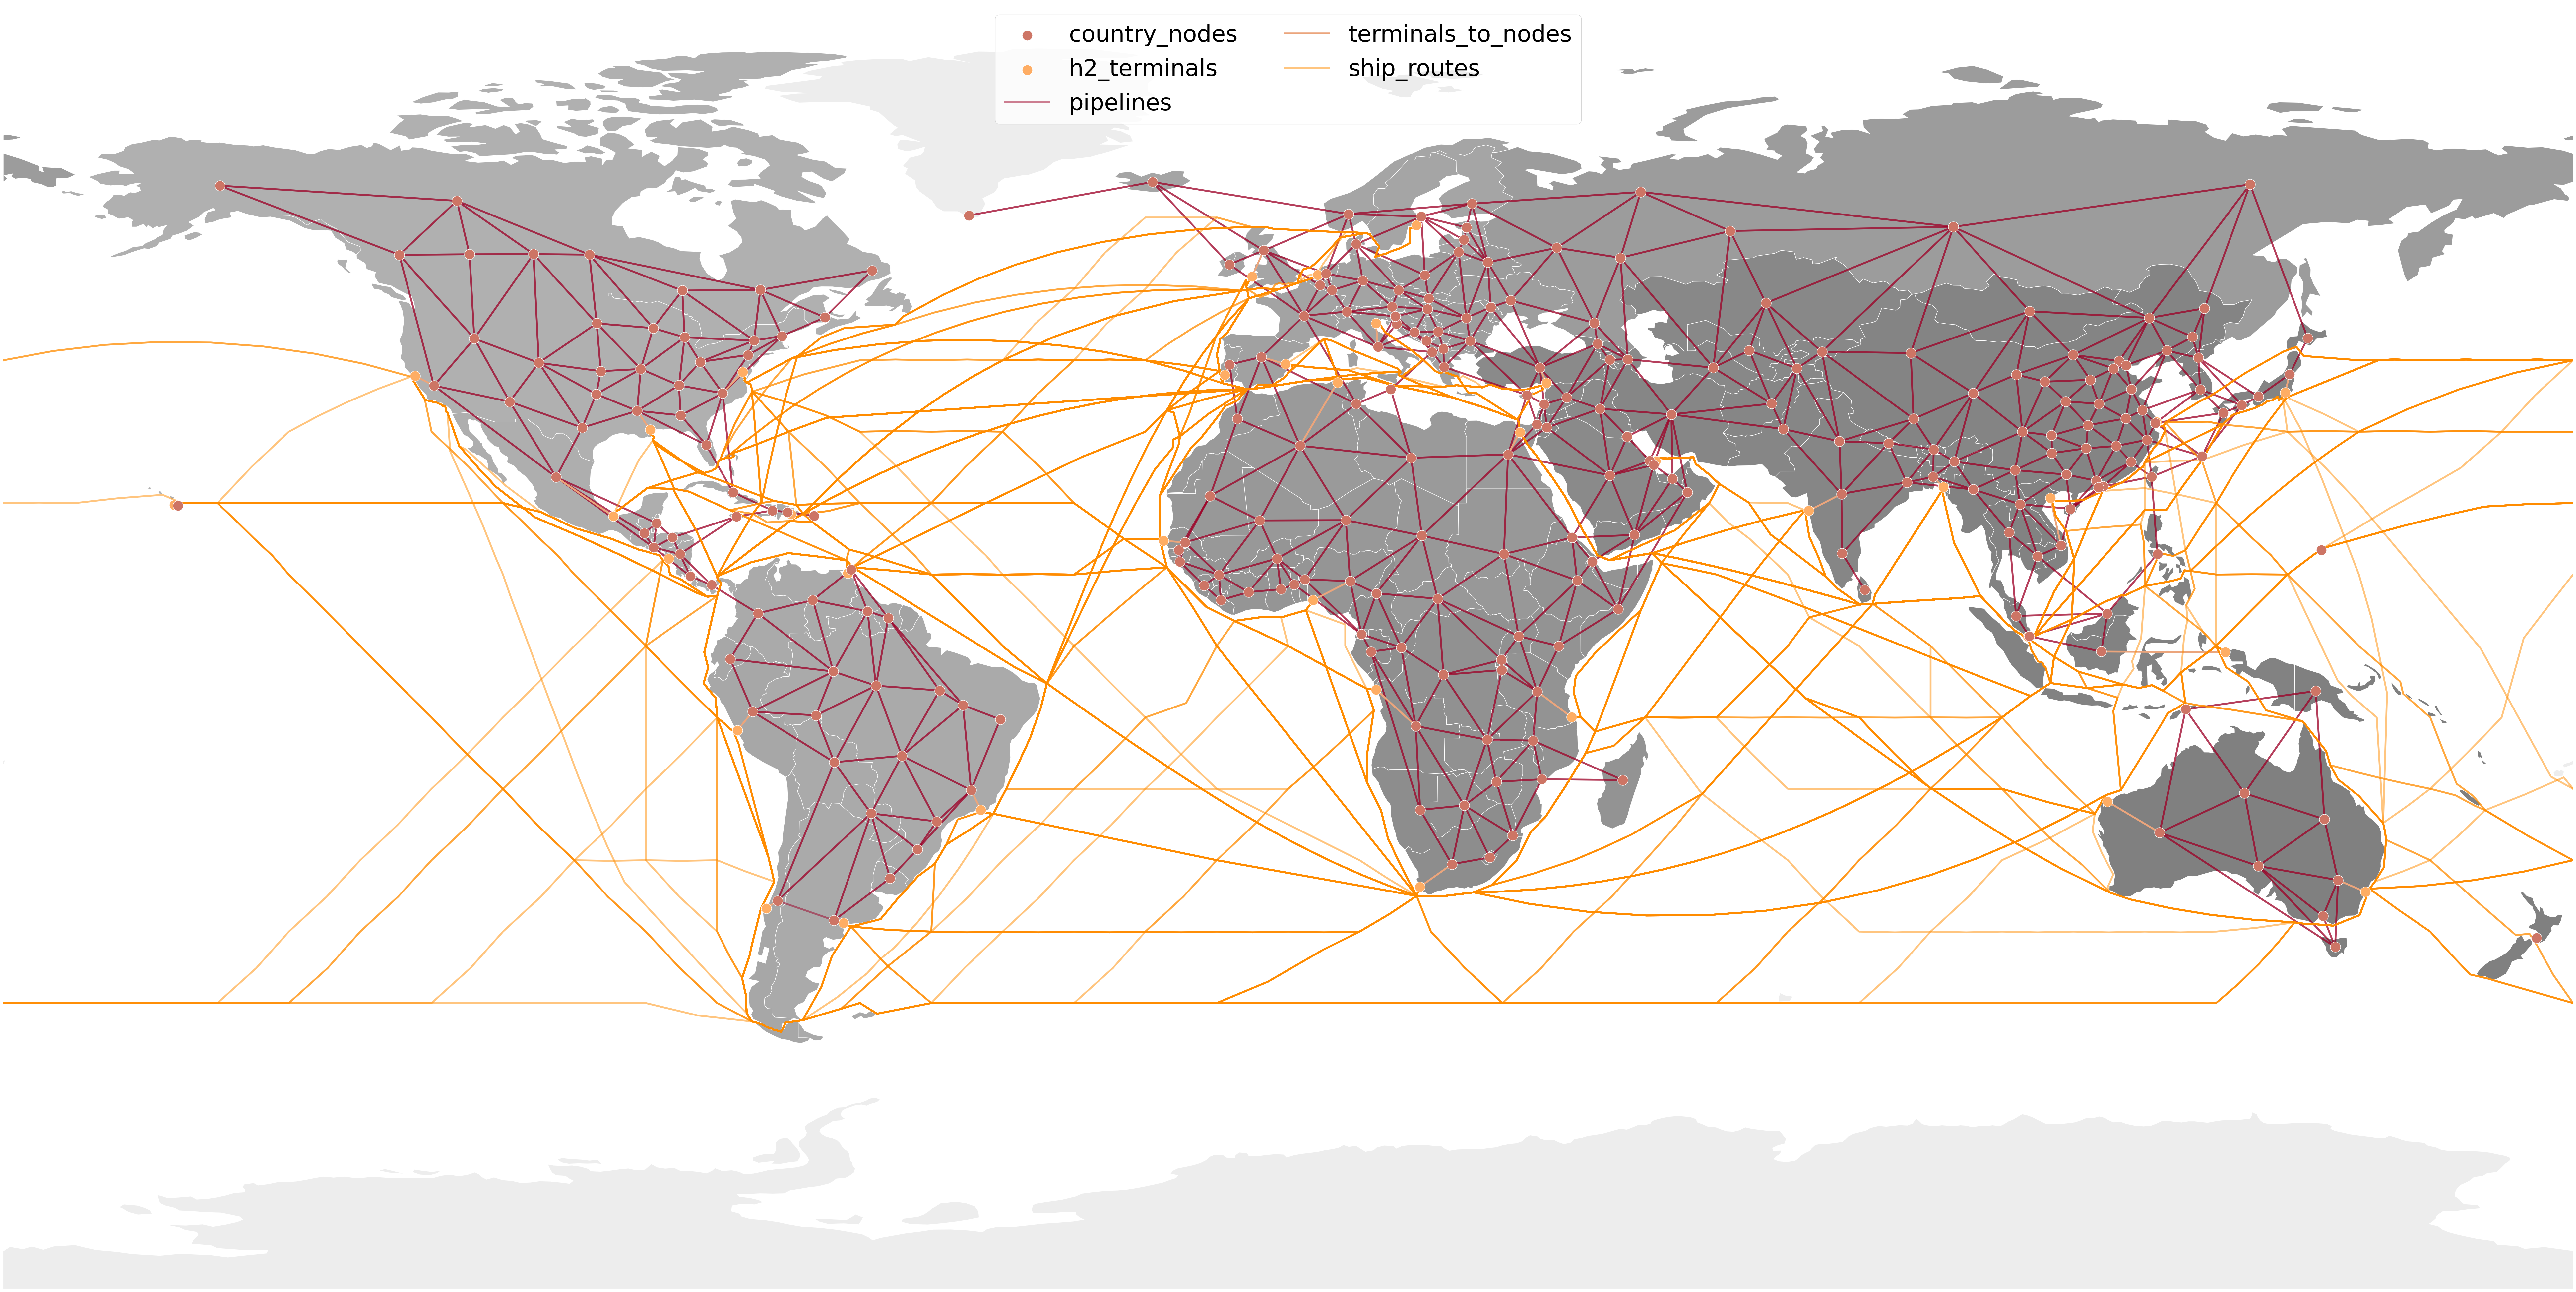

In [100]:
base = world.plot(color='#a8a8a8', linewidth=0.5, edgecolor='white', figsize=(100,80), alpha=0.2)
north_america.plot(ax=base, color="#b0b0b0", markersize=5, edgecolor='white')
central_america.plot(ax=base, color='#aeaeae', markersize=5, edgecolor='white')
caribbean.plot(ax=base, color='#acacac', markersize=5, edgecolor='white')
east_coast_south_america.plot(ax=base, color='#aaaaaa', markersize=5, edgecolor='white')
west_coast_south_america.plot(ax=base, color='#a7a7a7', markersize=5, edgecolor='white')
northern_europe.plot(ax=base, color='#a5a5a5', markersize=5, edgecolor='white')
central_europe.plot(ax=base, color='#a3a3a3', markersize=5, edgecolor='white')
southern_europe.plot(ax=base, color='#a1a1a1', markersize=5, edgecolor='white')
eastern_europe.plot(ax=base, color='#9e9e9e', markersize=5, edgecolor='white')
russia_belarus.plot(ax=base, color='#9c9c9c', markersize=5, edgecolor='white')
northern_africa.plot(ax=base, color='#9a9a9a', markersize=5, edgecolor='white')
sahel_zone.plot(ax=base, color='#989898', markersize=5, edgecolor='white')
north_west_coast_africa.plot(ax=base, color='#959595', markersize=5, edgecolor='white')
east_coast_africa.plot(ax=base, color='#939393', markersize=5, edgecolor='white')
south_central_africa.plot(ax=base, color='#919191', markersize=5, edgecolor='white')
west_coast_africa.plot(ax=base, color='#8f8f8f', markersize=5, edgecolor='white')
southern_africa.plot(ax=base, color='#8d8d8d', markersize=5, edgecolor='white')
middle_east.plot(ax=base, color='#8a8a8a', markersize=5, edgecolor='white')
central_asia.plot(ax=base, color='#888888', markersize=5, edgecolor='white')
southern_asia.plot(ax=base, color='#868686', markersize=5, edgecolor='white')
eastern_asia.plot(ax=base, color='#848484', markersize=5, edgecolor='white')
south_eastern_asia.plot(ax=base, color='#828282', markersize=5, edgecolor='white')
australia_oceania.plot(ax=base, color='#808080', markersize=5, edgecolor='white')
#cities.plot(ax=base, color='black', markersize=10, alpha=0.2)
#ports.plot(ax=base, color='black', markersize=20, alpha=0.2)
#rivers.plot(ax=base, color='blue', markersize=1, alpha=0.1)
plexos_nodes.plot(ax=base, color='#cd7565', markersize=500, alpha=1, edgecolors='white', label="country_nodes", zorder=3)
h2_terminals.plot(ax=base, color='#fead64', markersize=500, alpha=1,edgecolors='white', label="h2_terminals", zorder=2)
h2_pipelines.plot(ax=base, color='#9e0027', linewidth=4, edgecolor='white', alpha=0.5, label="pipelines", zorder=1) #Linestringelemente
con_line.plot(ax=base, color='#eba57c', linewidth=4, edgecolor='white', alpha=1, label="terminals_to_nodes", zorder=1) #Linestringelemente
df_sr.plot(ax=base, color='#ff8c00', linewidth=4, edgecolor='white', alpha=0.5, label="ship_routes", zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
#deepsea.plot(ax=base, color='blue', markersize=5, edgecolor='white')
base.set_axis_off()
plt.legend(loc="upper center", ncol=2, fontsize=50)
plt.ylim(-90,90)
plt.xlim(-180,180)

Now the exports for Spine will be prepared:

What do I need?
- Nodes (node, node_el, node_h2, balance_type = balance_type_node, demand_el, demand_h2, y (latitude*(-1)), x (longitude))
- h2_terminals (node, node_h2,  balance_type = balance_type_node, demand_el, demand_h2, y (latitude*(-1)), x (longitude))
- connection (node1, node2, name, fix_ratio_out_in_connection_flow, length)
- connection__from_node (node1, node2)
- connection__to_node (node1, node2, connection_capacity)
- cuppling units ()
- unit__node__node ()
- unit__to_node ()
- unit__from_node ()

In [101]:
terminals = h2_terminals
terminals = terminals.rename(columns={"longitude":"x", "latitude":"y"})
terminals["y"] = terminals["y"]*(-1)
terminals["length"] = con_line["length"]
terminals["balance_type"] = "balance_type_node"

terminals.head()

name           city    node           region          y   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe -51.948455  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe -37.961098   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe -39.463713   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe -45.205817   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east -36.825941   

           x                   geometry    length       balance_type  
0   4.140296   POINT (4.14030 51.94846)  1.165613  balance_type_node  
1  -8.878688  POINT (-8.87869 37.96110)  1.580536  balance_type_node  
2  -0.358820  POINT (-0.35882 39.46371)  3.534787  balance_type_node  
3  12.293656  POINT (12.29366 45.20582)  3.345095  balance_type_node  
4  36.177898  POINT (36.17790 36.82594)  2.333161  balance_type_node

In [102]:
# create a excel writer object and export the preprocessed transport model data
with pd.ExcelWriter(os.path.join(data_pth_output, "transport_objects.xlsx")) as writer:
   
    # use to_excel function and specify the sheet_name and index to store the dataframe in specified sheet
    test_df.to_excel(writer, sheet_name="nodes", index=False)
    h2_pipelines.to_excel(writer, sheet_name="h2_pipelines", index=False)
    terminals.to_excel(writer, sheet_name="h2_ships", index=False)
    con_line.to_excel(writer, sheet_name="terminal_connections", index=False)
    df_sr.to_excel(writer, sheet_name="shipping_routes", index=False)

Now that the model is exported - from here on the script aims to investigate and visualize the model results

In [112]:
data_pth_model_results = "../model/.spinetoolbox/items/spineopttotable_xlsx/output/" #define model results source folder
h2_pipelines_results = pd.read_excel(os.path.join(data_pth_model_results, "exported_db_url@Output.xlsx"), sheet_name=0, header = None)
h2_pipelines_results = h2_pipelines_results.transpose()
h2_pipelines_results.columns = h2_pipelines_results.iloc[0]
h2_pipelines_results = h2_pipelines_results[1:]
h2_pipelines_results.columns.values[0] = "definition"
h2_pipelines_results.columns.values[2] = "connection_type"

ship_con_results = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_slack_pos"].index)

h2_pipelines_results

0                                definition                model   
1                           connection_flow  AF-AGO_h2_AF-BWA_h2  \
2                           connection_flow  AF-AGO_h2_AF-BWA_h2   
3                           connection_flow  AF-AGO_h2_AF-BWA_h2   
4                           connection_flow  AF-AGO_h2_AF-BWA_h2   
5                           connection_flow  AF-AGO_h2_AF-COD_h2   
...                                     ...                  ...   
8616                         node_slack_pos            SA-URY_h2   
8617                         node_slack_pos            SA-VEN_h2   
8618        objective_connection_flow_costs               simple   
8619  objective_connection_investment_costs               simple   
8620                            total_costs               simple   

0    connection_type         node 2000-01-01T00:00:00 2000-01-02T00:00:00  
1          from_node    AF-AGO_h2                   0                   0  
2          from_node    AF-BWA_h2                   0                   0  
3            to_node    AF-AGO_h2                   0                   0  
4            to_node    AF-BWA_h2                   0                   0  
5          from_node    AF-AGO_h2                   0                   0  
...              ...          ...                 ...                 ...  
8616             NaN  realization                   0                   0  
8617             NaN  realization                   0                   0  
8618             NaN          NaN                   0                 NaN  
8619             NaN          NaN                   0                 NaN  
8620             NaN          NaN    399536597.555923                 NaN  

[8620 rows x 6 columns]

In [117]:
#import model  result data
h2_pipelines_results = pd.read_excel(os.path.join(data_pth_model_results, "exported_db_url@Output.xlsx"), sheet_name=0, header = None)
h2_pipelines_results = h2_pipelines_results.transpose()
h2_pipelines_results.columns = h2_pipelines_results.iloc[0]
h2_pipelines_results = h2_pipelines_results[1:]
h2_pipelines_results.columns.values[0] = "definition"
h2_pipelines_results.columns.values[2] = "connection_type"


#preprocessing of nodal results
node_slack_pos = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_slack_pos"].index)
node_slack_pos = node_slack_pos.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
node_slack_pos = node_slack_pos.rename(columns={"node":"h2_node"})
node_slack_pos = test_df.merge(node_slack_pos, how="left")
node_slack_pos = node_slack_pos.rename(columns={"2000-01-01T00:00:00":"slack_p"})

node_slack_neg = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_slack_neg"].index)
node_slack_neg = node_slack_neg.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
node_slack_neg = node_slack_neg.rename(columns={"node":"h2_node"})
node_slack_neg = node_slack_pos.merge(node_slack_neg, how="left")
node_slack_neg = node_slack_neg.rename(columns={"2000-01-01T00:00:00":"slack_n"})

node_injection = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["definition"] != "node_injection"].index)
node_injection = node_injection.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
node_injection = node_injection.rename(columns={"node":"h2_node"})
node_injection = node_slack_neg.merge(node_injection, how="left")
node_injection = node_injection.rename(columns={"2000-01-01T00:00:00":"injection"})
# node_injection["value"] = node_injection["value"].abs() #optional if representation shall be as dot diameter and not in a bar graph

#preprocessing of pipeline results
h2_pipelines_results = h2_pipelines_results.drop(h2_pipelines_results[h2_pipelines_results["connection_type"] == "to_node"].index)
h2_pipelines_results = h2_pipelines_results.drop(columns=["connection_type","definition","stochastic_scenario","2000-01-02T00:00:00"])
h2_pipelines_results = h2_pipelines_results.rename(columns={"node":"name"})
h2_pipelines_results = h2_pipelines_results.rename(columns={"2000-01-01T00:00:00":"flow"})
h2_shipping_results = df_sr.merge(h2_pipelines_results, how="left")
max_flow_pipeline = h2_pipelines_results["flow"].max()
h2_conline_results = con_line.merge(h2_pipelines_results, how="left")
max_flow_terminal = h2_conline_results["flow"].max()
h2_pipelines_results = h2_pipelines.merge(h2_pipelines_results, how="left")
max_flow_ship = h2_shipping_results["flow"].max()

node_results = node_injection #binding together the results for slack and injection with the original demand information of the nodes

#preprocessing of node information
test_df_none = test_df.drop(test_df[test_df["balance_type"] == "balance_type_node"].index)

# #h2_pipelines_results
# #df_sr_results
# #test_df_none
# node_slack_pos
# node_injection
#node_results
#h2_pipelines_results
#h2_shipping_results
#h2_conline_results
#max_flow

name                     geometry    el_node    h2_node  el_demand   
0    AF-AGO   POINT (17.87389 -11.20269)  AF-AGO_el  AF-AGO_h2          1  \
1    AF-BDI    POINT (29.91889 -3.37306)  AF-BDI_el  AF-BDI_h2          1   
2    AF-BEN      POINT (2.31583 9.30769)  AF-BEN_el  AF-BEN_h2          1   
3    AF-BFA    POINT (-1.56159 12.23833)  AF-BFA_el  AF-BFA_h2          1   
4    AF-BWA   POINT (24.68487 -22.32847)  AF-BWA_el  AF-BWA_h2          1   
..      ...                          ...        ...        ...        ...   
254  SA-PER   POINT (-75.01515 -9.18997)  SA-PER_el  SA-PER_h2          1   
255  SA-PRY  POINT (-58.44383 -23.44250)  SA-PRY_el  SA-PRY_h2          1   
256  SA-SUR    POINT (-56.02778 3.91931)  SA-SUR_el  SA-SUR_h2          1   
257  SA-URY  POINT (-55.76584 -32.52278)  SA-URY_el  SA-URY_h2          1   
258  SA-VEN    POINT (-66.58973 6.42375)  SA-VEN_el  SA-VEN_h2          1   

     h2_demand       balance_type          x          y   
0     0.873795  balance_type_node  17.873887  11.202692  \
1     9.134629  balance_type_node  29.918886   3.373056   
2     0.612635  balance_type_none   2.315834  -9.307690   
3     3.148508  balance_type_none  -1.561593 -12.238333   
4     4.216042  balance_type_node  24.684866  22.328474   
..         ...                ...        ...        ...   
254   2.671416  balance_type_none -75.015152   9.189967   
255   1.202992  balance_type_node -58.443832  23.442503   
256   0.301977  balance_type_node -56.027783  -3.919305   
257   3.596369  balance_type_node -55.765835  32.522779   
258   9.612915  balance_type_node -66.589730  -6.423750   

                                          el_demand_ts   
0    {"type": "time_series", "data": {"2015-01-01T0...  \
1    {"type": "time_series", "data": {"2015-01-01T0...   
2    {"type": "time_series", "data": {"2015-01-01T0...   
3    {"type": "time_series", "data": {"2015-01-01T0...   
4    {"type": "time_series", "data": {"2015-01-01T0...   
..                                                 ...   
254  {"type": "time_series", "data": {"2015-01-01T0...   
255  {"type": "time_series", "data": {"2015-01-01T0...   
256  {"type": "time_series", "data": {"2015-01-01T0...   
257  {"type": "time_series", "data": {"2015-01-01T0...   
258  {"type": "time_series", "data": {"2015-01-01T0...   

                                          h2_demand_ts  node_slack_penalty   
0    {"type": "time_series", "data": {"2015-01-01T0...             1000000  \
1    {"type": "time_series", "data": {"2015-01-01T0...             1000000   
2    {"type": "time_series", "data": {"2015-01-01T0...             1000000   
3    {"type": "time_series", "data": {"2015-01-01T0...             1000000   
4    {"type": "time_series", "data": {"2015-01-01T0...             1000000   
..                                                 ...                 ...   
254  {"type": "time_series", "data": {"2015-01-01T0...             1000000   
255  {"type": "time_series", "data": {"2015-01-01T0...             1000000   
256  {"type": "time_series", "data": {"2015-01-01T0...             1000000   
257  {"type": "time_series", "data": {"2015-01-01T0...             1000000   
258  {"type": "time_series", "data": {"2015-01-01T0...             1000000   

    model slack_p slack_n injection  
0     NaN     NaN     NaN       NaN  
1     NaN     NaN     NaN       NaN  
2     NaN     NaN     NaN       NaN  
3     NaN     NaN     NaN       NaN  
4     NaN     NaN     NaN       NaN  
..    ...     ...     ...       ...  
254   NaN     NaN     NaN       NaN  
255   NaN     NaN     NaN       NaN  
256   NaN     NaN     NaN       NaN  
257   NaN     NaN     NaN       NaN  
258   NaN     NaN     NaN       NaN  

[259 rows x 16 columns]

c:\Users\oliver\mambaforge\envs\geo_tools\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


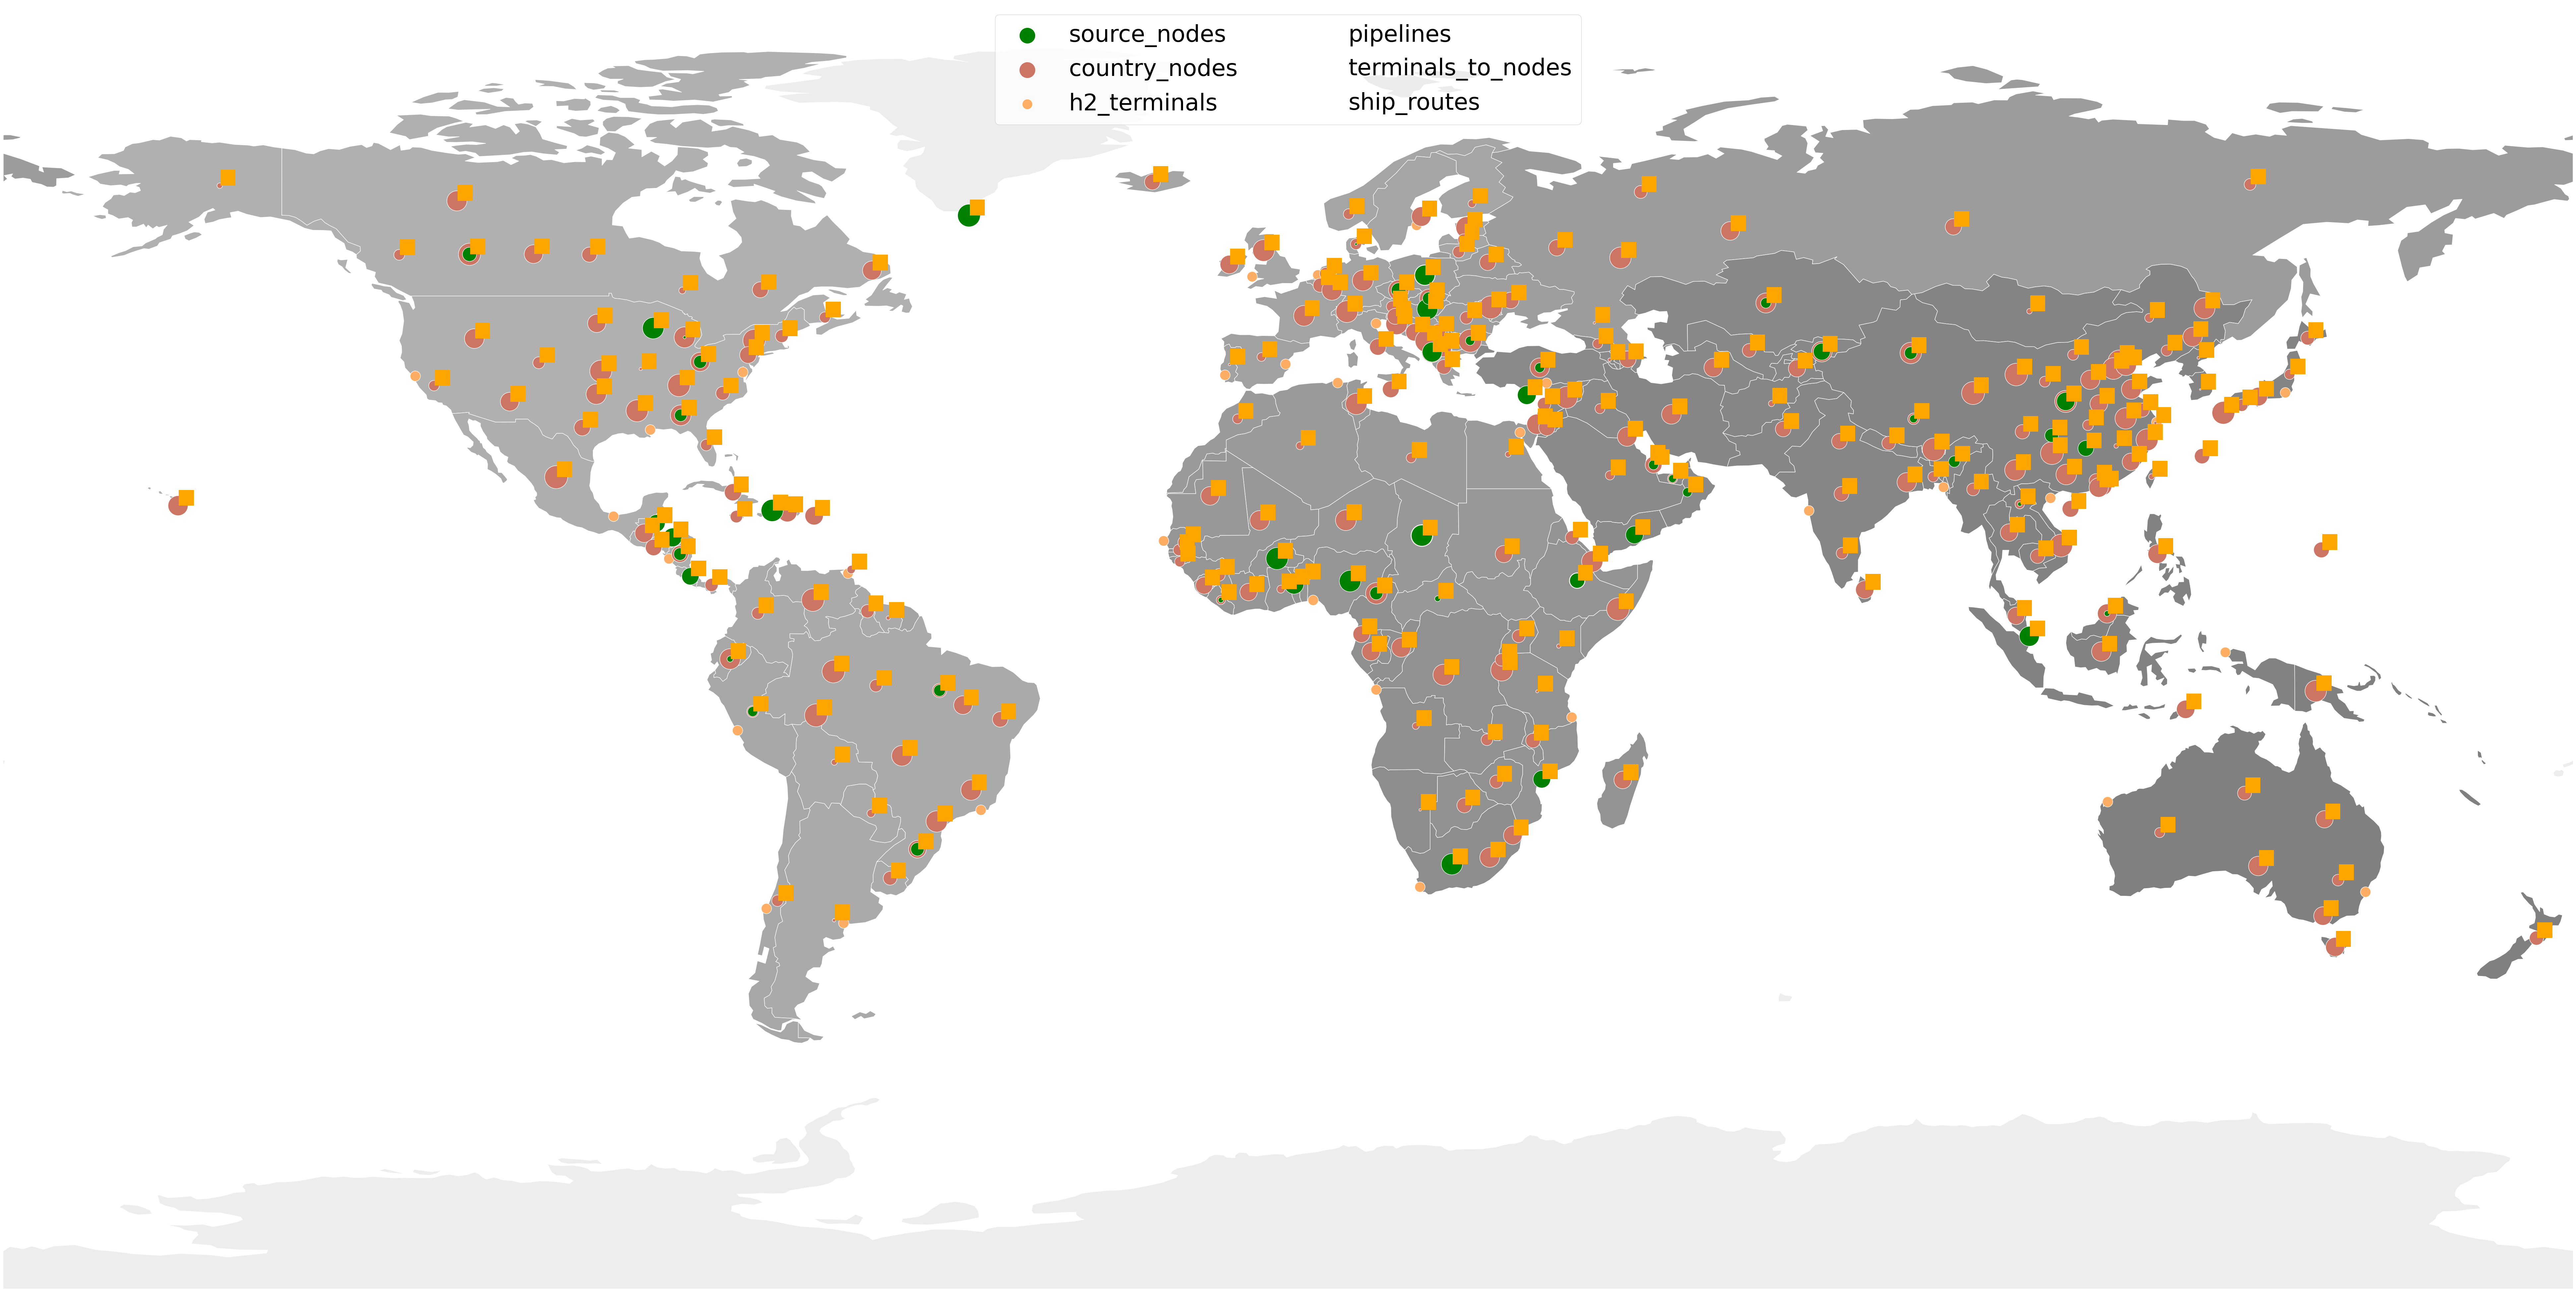

In [114]:
#How to insert bar charts into map diagrams
#code source: https://stackoverflow.com/questions/55854988/subplots-onto-a-basemap/55890475#55890475
#https://stackoverflow.com/questions/75825601/how-can-i-add-bar-charts-at-certain-locations-to-a-geopandas-map-using-the-same/75848560#75848560


#from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import mpl_toolkits
import numpy as np
import matplotlib.patches as mpatches

# function to create inset axes and plot bar chart on it
# this is good for 3 items bar chart
def build_bar(mapx, mapy, ax, width, xvals=['a','b','c'], yvals=[1,4,2], fcolors=['r','y','b']):
    ax_h = inset_axes(ax, width=width, \
                    height=width, \
                    loc=3, \
                    bbox_to_anchor=(mapx, mapy), \
                    bbox_transform=ax.transData, \
                    borderpad=0, \
                    axes_kwargs={'alpha': 0.35, 'visible': True})
    for x,y,c in zip(xvals, yvals, fcolors):
        ax_h.bar(x, y, label=str(x), fc=c)
    #ax.xticks(range(len(xvals)), xvals, fontsize=10, rotation=30)
    ax_h.axis('off')
    return ax_h

base = world.plot(color='#a8a8a8', linewidth=0.5, edgecolor='white', figsize=(100,80), alpha=0.2)
north_america.plot(ax=base, color="#b0b0b0", markersize=5, edgecolor='white')
central_america.plot(ax=base, color='#aeaeae', markersize=5, edgecolor='white')
caribbean.plot(ax=base, color='#acacac', markersize=5, edgecolor='white')
east_coast_south_america.plot(ax=base, color='#aaaaaa', markersize=5, edgecolor='white')
west_coast_south_america.plot(ax=base, color='#a7a7a7', markersize=5, edgecolor='white')
northern_europe.plot(ax=base, color='#a5a5a5', markersize=5, edgecolor='white')
central_europe.plot(ax=base, color='#a3a3a3', markersize=5, edgecolor='white')
southern_europe.plot(ax=base, color='#a1a1a1', markersize=5, edgecolor='white')
eastern_europe.plot(ax=base, color='#9e9e9e', markersize=5, edgecolor='white')
russia_belarus.plot(ax=base, color='#9c9c9c', markersize=5, edgecolor='white')
northern_africa.plot(ax=base, color='#9a9a9a', markersize=5, edgecolor='white')
sahel_zone.plot(ax=base, color='#989898', markersize=5, edgecolor='white')
north_west_coast_africa.plot(ax=base, color='#959595', markersize=5, edgecolor='white')
east_coast_africa.plot(ax=base, color='#939393', markersize=5, edgecolor='white')
south_central_africa.plot(ax=base, color='#919191', markersize=5, edgecolor='white')
west_coast_africa.plot(ax=base, color='#8f8f8f', markersize=5, edgecolor='white')
southern_africa.plot(ax=base, color='#8d8d8d', markersize=5, edgecolor='white')
middle_east.plot(ax=base, color='#8a8a8a', markersize=5, edgecolor='white')
central_asia.plot(ax=base, color='#888888', markersize=5, edgecolor='white')
southern_asia.plot(ax=base, color='#868686', markersize=5, edgecolor='white')
eastern_asia.plot(ax=base, color='#848484', markersize=5, edgecolor='white')
south_eastern_asia.plot(ax=base, color='#828282', markersize=5, edgecolor='white')
australia_oceania.plot(ax=base, color='#808080', markersize=5, edgecolor='white')
test_df_none.plot(ax=base, color='green', markersize=test_df["h2_demand"]*250, alpha=1, edgecolors='white', label="source_nodes", zorder=5) #balance_type differentiation
node_results.plot(ax=base, color='#cd7565', markersize=node_results["h2_demand"]*250, alpha=1, edgecolors='white', label="country_nodes", zorder=4) #demand overlay
#node_results.plot(ax=base, color='red', markersize=node_results["slack"]*250, alpha=1, edgecolors='white', label="node_slack", zorder=4) #node slack
#node_results.plot(ax=base, color='purple', markersize=node_results["injection"]*250, alpha=1, edgecolors='white', label="node_injection", zorder=3) #node injection
h2_terminals.plot(ax=base, color='#fead64', markersize=500, alpha=1,edgecolors='white', label="h2_terminals", zorder=2)
h2_pipelines_results.plot(ax=base, column='name', cmap='BuGn', linewidth=h2_pipelines_results['flow']/max_flow_pipeline*1000, label="pipelines", edgecolor='#9e0027', alpha=1, vmin=0, vmax=1) #h2_pipelines_results['flow']/1000000+0.5 h2_pipelines_results['flow']/max_flow_pipeline*1000
h2_conline_results.plot(ax=base, color='#eba57c', linewidth=h2_conline_results['flow']/max_flow_terminal*10, edgecolor='white', alpha=1, label="terminals_to_nodes", zorder=1) #Linestringelemente
h2_shipping_results.plot(ax=base, column='name', cmap='BuGn', linewidth=h2_shipping_results['flow']/max_flow_ship*10, color='#ff8c00', edgecolor='white', alpha=1, label="ship_routes", zorder=1) #Linestringelemente
plt.legend(loc="upper center", ncol=2, fontsize=50)
plt.ylim(-90,90)
plt.xlim(-180,180)

# create a barchart at each location in (lon1s,lat1s)
# ---------------------------------------------------
bar_width = 0.1  # inch
colors = ['orange','purple','red']
for i in node_results.index:
    x1 = node_results["x"][i]   # get data coordinates for plotting
    y1 = node_results["y"][i]*(-1)   # get data coordinates for plotting
    bax = build_bar(x1, y1, base, width=0.5, xvals=("h2_demand", "injection", "slack_n"), \
              yvals = [node_results["h2_demand"][i], node_results["injection"][i], node_results["slack_n"][i]], \
              fcolors=colors)

base.set_axis_off()

#über colorband machen? https://matplotlib.org/stable/tutorials/colors/colormaps.html